[COMMAND] RUNNING: IMPORTING LIBRARIES...
[COMMAND] COMPLETED: LIBRARIES IMPORTED ✓

[COMMAND] RUNNING: LOAD IMAGE...
[COMMAND] COMPLETED: IMAGE LOADED ✓ | Shape = (1536, 1024, 3)

[COMMAND] RUNNING: DESATURATION METHOD...
[COMMAND] COMPLETED: DESATURATION METHOD ✓

[COMMAND] RUNNING: MEDIAN-CUT METHOD INITIALIZATION...
[COMMAND] COMPLETED: MEDIAN-CUT METHOD READY ✓

[COMMAND] RUNNING: OCTREE METHOD INITIALIZATION...
[COMMAND] COMPLETED: OCTREE METHOD READY ✓

[COMMAND] RUNNING: DISPLAYING ALL METHOD RESULTS...



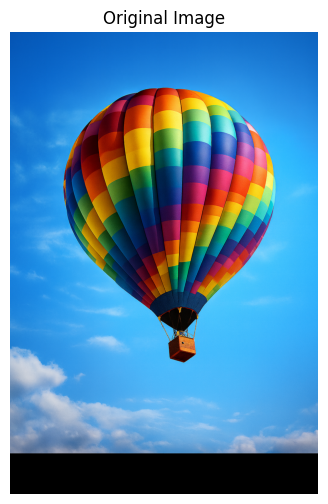

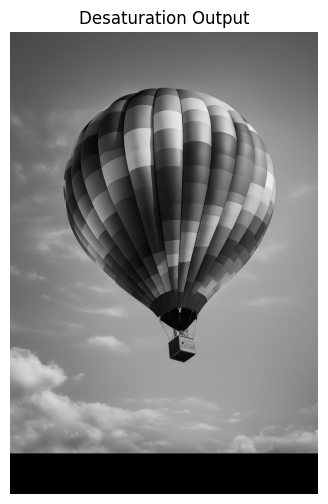

[COMMAND] RUNNING: MEDIAN-CUT K=4...


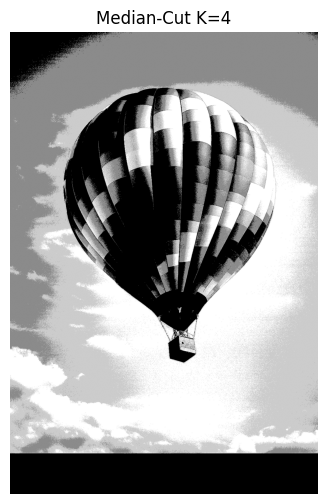

[COMMAND] COMPLETED: MEDIAN-CUT K=4 ✓ | Palette size = 4
[COMMAND] RUNNING: MEDIAN-CUT K=8...


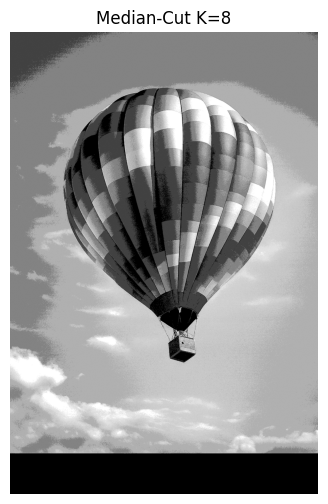

[COMMAND] COMPLETED: MEDIAN-CUT K=8 ✓ | Palette size = 8
[COMMAND] RUNNING: MEDIAN-CUT K=16...


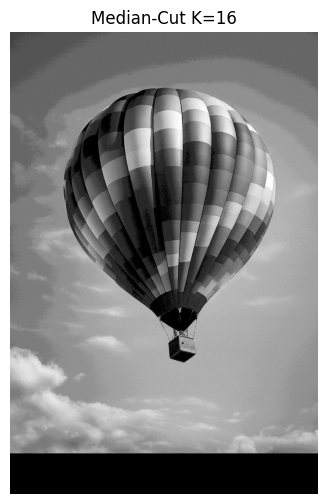

[COMMAND] COMPLETED: MEDIAN-CUT K=16 ✓ | Palette size = 16

[COMMAND] RUNNING: OCTREE K=4...


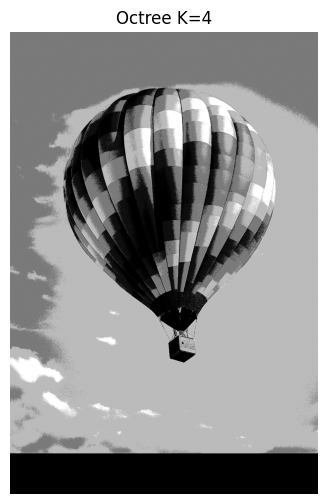

[COMMAND] COMPLETED: OCTREE K=4 ✓ | Palette size = 4

[COMMAND] RUNNING: OCTREE K=8...


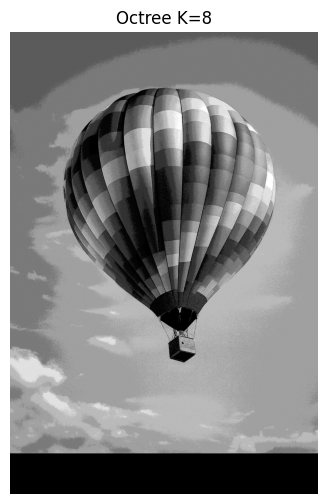

[COMMAND] COMPLETED: OCTREE K=8 ✓ | Palette size = 8

[COMMAND] RUNNING: OCTREE K=16...


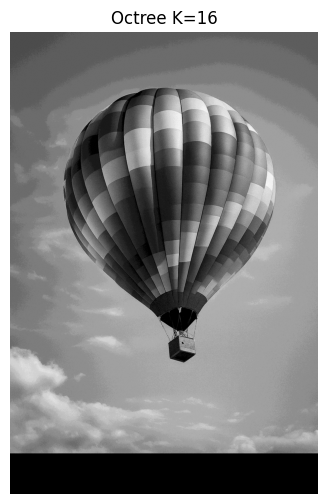

[COMMAND] COMPLETED: OCTREE K=16 ✓ | Palette size = 16

[COMMAND] ALL METHODS COMPLETED SUCCESSFULLY ✓✓✓


In [1]:
# ============================================================
# STEP 0: IMPORT LIBRARIES
# ============================================================
print("[COMMAND] RUNNING: IMPORTING LIBRARIES...")
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
print("[COMMAND] COMPLETED: LIBRARIES IMPORTED ✓")


# ============================================================
# STEP 1: LOAD IMAGE
# ============================================================
print("\n[COMMAND] RUNNING: LOAD IMAGE...")

image_path = "/content/ChatGPT Image Nov 25, 2025, 11_32_39 AM.png"
img = Image.open(image_path).convert("RGB")
arr = np.array(img)

print("[COMMAND] COMPLETED: IMAGE LOADED ✓ | Shape =", arr.shape)


# ============================================================
# GRAYSCALE (LUMINANCE HELPER)
# ============================================================
def rgb_to_luminance(rgb_arr):
    r = rgb_arr[...,0]
    g = rgb_arr[...,1]
    b = rgb_arr[...,2]
    lum = 0.299*r + 0.587*g + 0.114*b
    return lum.astype(np.uint8)


# ============================================================
# STEP 2: DESATURATION METHOD
# ============================================================
print("\n[COMMAND] RUNNING: DESATURATION METHOD...")

desat = rgb_to_luminance(arr)

print("[COMMAND] COMPLETED: DESATURATION METHOD ✓")


# ============================================================
# DISPLAY HELPER
# ============================================================
def show_image(title, data, cmap='gray'):
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(data, cmap=cmap)
    plt.axis('off')
    plt.show()


# ============================================================
# STEP 3: MEDIAN-CUT METHOD
# ============================================================
print("\n[COMMAND] RUNNING: MEDIAN-CUT METHOD INITIALIZATION...")

def median_cut_grayscale(rgb_arr, K=16):
    lum = rgb_to_luminance(rgb_arr).flatten()
    H, W, _ = rgb_arr.shape

    boxes = [np.arange(len(lum))]

    while len(boxes) < K:
        ranges = [(lum[b].max() - lum[b].min()) for b in boxes]
        idx = np.argmax(ranges)
        box = boxes.pop(idx)

        sorted_box = box[np.argsort(lum[box])]
        mid = len(sorted_box) // 2

        boxes.append(sorted_box[:mid])
        boxes.append(sorted_box[mid:])

    out = np.zeros_like(lum)

    palette = []
    for b in boxes:
        meanv = int(np.mean(lum[b]))
        palette.append(meanv)
        out[b] = meanv

    return out.reshape((H,W)), palette

print("[COMMAND] COMPLETED: MEDIAN-CUT METHOD READY ✓")


# ============================================================
# STEP 4: OCTREE METHOD
# ============================================================
print("\n[COMMAND] RUNNING: OCTREE METHOD INITIALIZATION...")

class Leaf:
    def __init__(self):
        self.count = 0
        self.sum = 0

def octree_grayscale(rgb_arr, K=16):
    H, W, _ = rgb_arr.shape
    lum = rgb_to_luminance(rgb_arr).flatten()

    nodes = {(0,0): Leaf()}

    for v in lum:
        idx = 0
        for level in range(1,9):
            bit = (v >> (8-level)) & 1
            idx = (idx << 1) | bit
            if (level, idx) not in nodes:
                nodes[(level, idx)] = Leaf()
            nodes[(level, idx)].count += 1
            nodes[(level, idx)].sum += int(v)

    def get_leaves():
        return [(lvl, idx) for (lvl, idx), leaf in nodes.items()
                if leaf.count > 0 and
                all((lvl+1, (idx<<1)|b) not in nodes for b in [0,1])]

    leaves = get_leaves()
    while len(leaves) > K:
        deepest = max(leaves)
        del nodes[deepest]
        leaves = get_leaves()

    def map_value(v):
        idx = 0
        last = nodes[(0,0)]
        for level in range(1,9):
            bit = (v >> (8-level)) & 1
            idx = (idx << 1) | bit
            if (level, idx) in nodes:
                last = nodes[(level, idx)]
        return int(last.sum / last.count)

    out = np.array([map_value(v) for v in lum]).reshape((H,W))
    palette = [int(nodes[k].sum / nodes[k].count) for k in leaves]

    return out.astype(np.uint8), palette

print("[COMMAND] COMPLETED: OCTREE METHOD READY ✓")


# ============================================================
# STEP 5: SHOW IMAGES + EXECUTE COMMANDS
# ============================================================
print("\n[COMMAND] RUNNING: DISPLAYING ALL METHOD RESULTS...\n")

show_image("Original Image", img, cmap=None)
show_image("Desaturation Output", desat)

Ks = [4, 8, 16]

for K in Ks:
    print(f"[COMMAND] RUNNING: MEDIAN-CUT K={K}...")
    out_med, pal_med = median_cut_grayscale(arr, K)
    show_image(f"Median-Cut K={K}", out_med)
    print(f"[COMMAND] COMPLETED: MEDIAN-CUT K={K} ✓ | Palette size =", len(pal_med))

for K in Ks:
    print(f"\n[COMMAND] RUNNING: OCTREE K={K}...")
    out_oct, pal_oct = octree_grayscale(arr, K)
    show_image(f"Octree K={K}", out_oct)
    print(f"[COMMAND] COMPLETED: OCTREE K={K} ✓ | Palette size =", len(pal_oct))

print("\n[COMMAND] ALL METHODS COMPLETED SUCCESSFULLY ✓✓✓")
